In [1]:
! pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.multiprocessing as mp

import gym
import os
from torch import nn
import torch
import numpy as np
import pickle


In [3]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
import matplotlib.pyplot as plt


class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
            nn.Softmax(dim=-1)
        )

        self.critic = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, state):
        action_probs = self.actor(state)
        value = self.critic(state)
        return action_probs, value


def convert_to_tensor(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    return state

def select_action(actor_critic, state):
    state = convert_to_tensor(state)
    action_probs, _ = actor_critic(state)
    arrange_action_probs = np.arange(len(action_probs[0]))
    action = np.random.choice(arrange_action_probs, p=action_probs.detach().numpy()[0])
    return action

def evaluate_action(actor_critic, state):
    state = convert_to_tensor(state)
    with torch.no_grad():
        value, action_probs = actor_critic(state)
    action = torch.argmax(action_probs).item()
    return action

def optimize_model(actor_critic, state, action, reward, next_state, done, optimizer, gamma):
    state = convert_to_tensor(state)
    next_state = convert_to_tensor(next_state)
    reward = torch.tensor([reward], dtype=torch.float32)
    done = torch.tensor([1 - int(done)], dtype=torch.float32)

    _, value = actor_critic(state)
    _, next_value = actor_critic(next_state)

    target = reward + gamma * next_value * done
    td_error = target - value

    action_probs, _ = actor_critic(state)
    log_prob = torch.log(action_probs.squeeze(0)[action])
    actor_loss = -log_prob * td_error.detach()

    critic_loss = td_error.pow(2)

    loss = actor_loss + critic_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def train_a3c(env_name, gamma, lr, max_episodes):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    actor_critic = ActorCritic(state_dim, action_dim)
    actor_critic.share_memory()
    optimizer = optim.Adam(actor_critic.parameters(), lr=lr)

    num_processes = mp.cpu_count()
    processes = []
    for rank in range(num_processes):
        p = mp.Process(target=run_a3c, args=(rank, actor_critic, env_name, gamma, lr, max_episodes))
        p.start()
        processes.append(p)
    for p in processes:
        p.join()


    with open('episode_rewards.pkl', 'rb') as f:
        episode_rewards = pickle.load(f)
    with open('avg_rewards.pkl', 'rb') as f:
        avg_reward_list = pickle.load(f)

    # plt.plot(np.arange(len(episode_rewards)), episode_rewards)
    # plt.xlabel('Episode')
    # plt.ylabel('Reward')
    # plt.title('Reward per Episode')
    # plt.show()

    # # plt.plot(np.arange(len(avg_rewards)), avg_rewards)
    # # plt.xlabel('Episode')
    # # plt.ylabel('Average Reward')
    # # plt.title('Average Reward per Episode')
    # # plt.show()
    plt.plot(episode_rewards, 'g', label='Reward')
    plt.plot(avg_reward_list, 'r', label='Average Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward Value')
    plt.title('Rewards Per Episode')
    plt.grid()
    plt.legend()
    plt.show()


    torch.save(actor_critic.state_dict(), 'actor_critic.pt')
    print('Model saved.')



In [4]:

def run_a3c(rank, actor_critic, env_name, gamma, lr, max_episodes):
    env = gym.make(env_name)
    env.seed(rank)
    torch.manual_seed(rank)

    optimizer = optim.Adam(actor_critic.parameters(), lr=lr)

    episode_rewards = []
    avg_reward_list = []
    for episode in range(max_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = select_action(actor_critic, state)
            env_list = env.step(action)
            next_state = env_list[0]
            reward = env_list[1]
            done = env_list[2]
            _ = env_list[3]
            total_reward += reward

            optimize_model(actor_critic, state, action, reward, next_state, done, optimizer, gamma)
            state = next_state

        episode_rewards.append(total_reward)
        avg_reward_list.append(sum(episode_rewards)/len(episode_rewards))
        if len(episode_rewards) >= 100:
            avg_reward = np.mean(episode_rewards[-100:])
            if rank == 0:
                print(f"Episode {episode}, Reward: {total_reward}, Avg Reward: {avg_reward}")

            with open('episode_rewards.pkl', 'wb') as f:
                pickle.dump(episode_rewards, f)
            with open('avg_rewards.pkl', 'wb') as f:
                pickle.dump(np.array(avg_reward_list), f)

            if avg_reward >= 500:
                if rank == 0:
                    print(f"Solved at episode {episode}: average reward of last 100 episodes is {avg_reward}")
                    torch.save(actor_critic.state_dict(), 'actor_critic.pt')
                    print('Model saved.')
                break

    env.close()




/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Episode 99, Reward: 96.0, Avg Reward: 44.0
Episode 100, Reward: 109.0, Avg Reward: 44.91
Episode 101, Reward: 66.0, Avg Reward: 45.41
Episode 102, Reward: 63.0, Avg Reward: 45.74
Episode 103, Reward: 46.0, Avg Reward: 46.06
Episode 104, Reward: 64.0, Avg Reward: 46.28
Episode 105, Reward: 148.0, Avg Reward: 47.54
Episode 106, Reward: 125.0, Avg Reward: 48.63
Episode 107, Reward: 54.0, Avg Reward: 48.99
Episode 108, Reward: 75.0, Avg Reward: 49.59
Episode 109, Reward: 52.0, Avg Reward: 49.94
Episode 110, Reward: 196.0, Avg Reward: 51.77
Episode 111, Reward: 95.0, Avg Reward: 52.05
Episode 112, Reward: 95.0, Avg Reward: 52.6
Episode 113, Reward: 142.0, Avg Reward: 53.9
Episode 114, Reward: 104.0, Avg Reward: 54.84
Episode 115, Reward: 87.0, Avg Reward: 55.48
Episode 116, Reward: 72.0, Avg Reward: 55.94
Episode 117, Reward: 76.0, Avg Reward: 56.39
Episode 118, Reward: 72.0, Avg Reward: 56.91
Episode 119, Reward: 127.0, Avg Reward: 57.97
Episode 120, Reward: 115.0, Avg Reward: 58.78
Episod

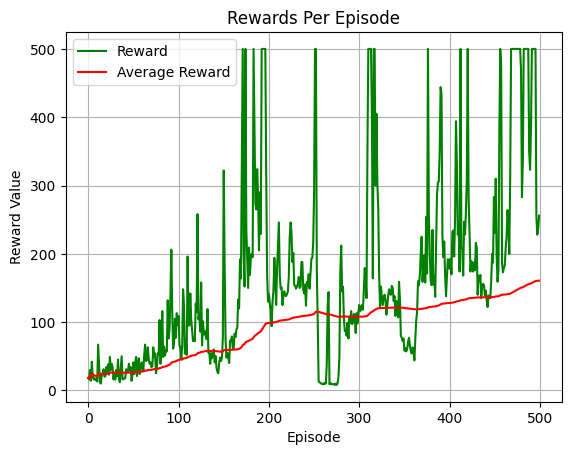

Model saved.


In [17]:
train_a3c(env_name='CartPole-v1', gamma=0.993, lr=0.001, max_episodes=500)


/usr/local/lib/python3.10/dist-packages/gym/envs/classic_control/cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


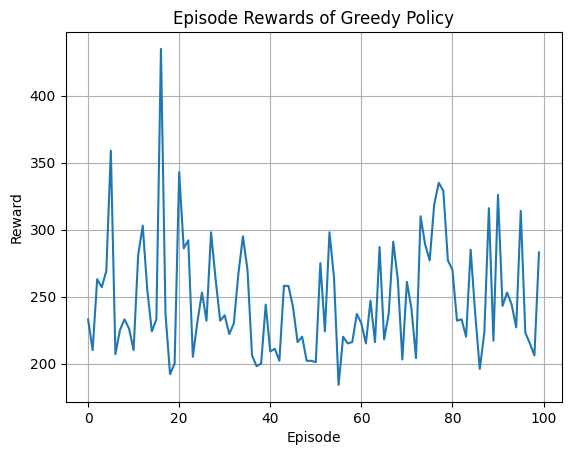

In [5]:
import pickle
import matplotlib.pyplot as plt
import torch
env = gym.make('CartPole-v1')
def evaluate_model(model, env, num_episodes):
    episode_rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
          action = select_action(model, state)
          env_list = env.step(action)
          observation = env_list[0]
          reward = env_list[1]
          done = env_list[2]
          _ = env_list[3]
          total_reward += reward
        # while not done:
        #     state = torch.from_numpy(state).float().unsqueeze(0)
        #     with torch.no_grad():
        #         value, action_probs = evaluate_action(state)
        #     action = torch.argmax(action_probs).item()
            # with torch.no_grad():
            #     # state_tensor = torch.FloatTensor(state)
            #     # action_probs = model(state_tensor)
            #     # print(type(action_probs))
            #     # action = torch.argmax(action_probs).item()
          env_list = env.step(action)
          next_state = env_list[0]
          reward = env_list[1]
          done = env_list[2]
          _ = env_list[3]
          total_reward += reward
          state = next_state
        episode_rewards.append(total_reward)
    return episode_rewards

model = ActorCritic(env.observation_space.shape[0], env.action_space.n)
model.load_state_dict(torch.load('actor_critic.pt'))

env = gym.make('CartPole-v1')
episode_rewards = evaluate_model(model, env, num_episodes=100)

with open('episode_rewards_eval.pkl', 'wb') as f:
    pickle.dump(episode_rewards, f)

plt.figure()
plt.plot(episode_rewards)
plt.title("Episode Rewards of Greedy Policy")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid()
plt.show()
